## Логистическая регрессия

In [1]:
from math import log, e

import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1.0, alpha=0.0005, max_epoch=100, penalty='l2', log_loss=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        penalty - тип регуляризации
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
        self.log_loss = log_loss
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y=None):
        """
        Обучение модели
        X - Тренировочные векторы [n_samples, n_features]
            n_samples - число образцов
            n_features - число признаков
        y - Вектор целевых значений [n_samples]
        """
        X = np.hstack((np.ones((X.shape[0], 1)), X)) # Первый столбец всегда 1

        n_samples, n_features = X.shape

        if self.w is None:
            self.w = np.random.randn(n_features, 1)

        self.loss_history = []

        for epoch in range(self.max_epoch):
            p = np.random.permutation(len(X))
            for idx in p:
                penalty = None
                xi = X[[idx]]
                yi = y[idx]
                gradients = xi.T.dot(self._sigmoid(np.dot(xi, self.w)) - yi)
                if self.penalty == 'l1':
                    penalty = self.C * np.sign(self.w)
                elif self.penalty == 'l2':
                    penalty = self.C * self.w
                if penalty is not None:
                    penalty[0] = 0 # Исключаем bias
                    gradients += penalty
                # gradients = 2 * xi.T.dot(xi.dot(self.w) - yi)
                self.w -= self.alpha * gradients
                if self.log_loss and idx % 100 == 0:
                    self.loss_history.append(self._log_loss_all(X, y))
        return self
    
    def partial_fit(self, X, y=None):
        """
        По желанию - метод дообучения модели на новых данных
        """
        return self
        
    def predict(self, X):
        """
        Возвращение метки класса
        """
        y_hat_proba = self.predict_proba(X)
        y_hat = np.argmax(y_hat_proba, axis=1)
        return y_hat

    def predict_proba(self, X):
        """
        Возвращение вероятности каждого из классов
        """
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        predictions = self._sigmoid(X.dot(self.w.flatten().T))
        y_hat_proba = np.vstack([1-predictions, predictions]).T
        return y_hat_proba

    def _log_loss_single(self, x, y):
        prediction = self._sigmoid(np.dot(x, self.w))
        loss = -np.log(prediction) if y == 1.0 else -np.log(1.0 - prediction)
        return loss[0]

    def _log_loss_all(self, X, y):
        predictions = self._sigmoid(np.dot(X, self.w))
        eps = 1e-15
        predictions = np.clip(predictions, eps, 1 - eps)
        loss = -np.sum(y * np.log(predictions) + (1.0 - y) * np.log(1.0 - predictions))
        penalty = 0
        if self.penalty == 'l1':
            penalty = self.C * la.norm(self.w[1:])
        elif self.penalty == 'l2':
            penalty = (self.C / 2.0 * self.w[1:].T.dot(self.w[1:]))[0][0]
        loss = loss / X.shape[0]
        return loss + penalty

    @staticmethod
    def _sigmoid(s):
        return 1.0 / (1.0 + np.exp(-s))

## Проверка на синтетических данных

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [3]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(500, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(500, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(500), np.zeros(500)]

### Построим график без регуляризации:

In [4]:
model = MySGDClassifier(max_epoch=100, penalty=None)
model.fit(X, y)

MySGDClassifier(C=1.0, alpha=0.0005, log_loss=False, max_epoch=100,
        penalty=None)

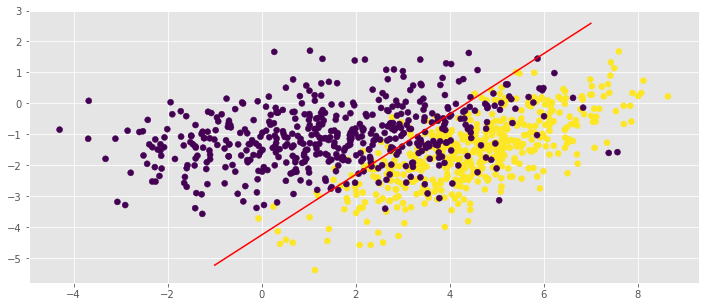

In [5]:
x_naive = np.array([-1, 7])
y_naive = -(model.w[0] + model.w[1] * x_naive) / model.w[2]
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(x_naive, y_naive, c='red', label='descision boundary naive');

### Построим график с уровнем регуляризации L1 с эмпирически подобранным параметром C:

In [6]:
model_l1 = MySGDClassifier(max_epoch=100, penalty='l1', C=0.01)
model_l1.fit(X, y)

MySGDClassifier(C=0.01, alpha=0.0005, log_loss=False, max_epoch=100,
        penalty='l1')

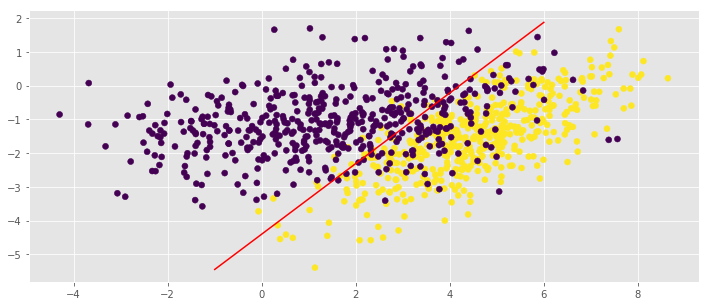

In [7]:
x_naive = np.array([-1, 6])
y_naive = -(model_l1.w[0] + model_l1.w[1] * x_naive) / model_l1.w[2]
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(x_naive, y_naive, c='red', label='descision boundary naive');

### Построим график с уровнем регуляризации L2 с эмпирически подобранным параметром C:

In [8]:
model_l2 = MySGDClassifier(max_epoch=100, penalty='l2', C=0.01)
model_l2.fit(X, y)

MySGDClassifier(C=0.01, alpha=0.0005, log_loss=False, max_epoch=100,
        penalty='l2')

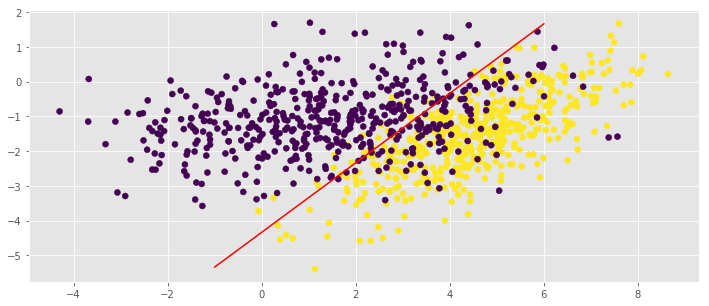

In [9]:
x_naive = np.array([-1, 6])
y_naive = -(model_l2.w[0] + model_l2.w[1] * x_naive) / model_l2.w[2]
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(x_naive, y_naive, c='red', label='descision boundary naive');

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

### Построим несколько графиков для alpha 0.005, 0.0005 и 0.00005 без регуляризации:

In [10]:
model_1 = MySGDClassifier(max_epoch=100, log_loss=True, penalty=None, alpha=0.005)
model_2 = MySGDClassifier(max_epoch=100, log_loss=True, penalty=None, alpha=0.0005)
model_3 = MySGDClassifier(max_epoch=100, log_loss=True, penalty=None, alpha=0.00005)

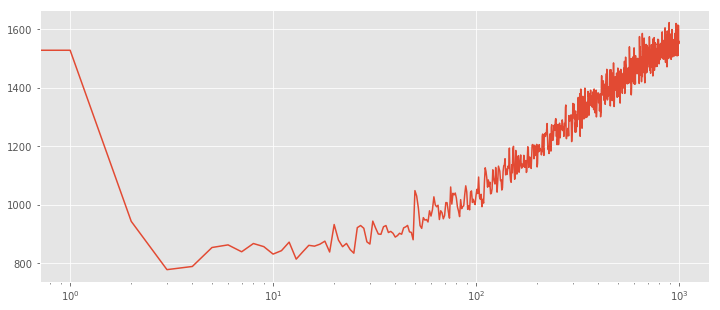

In [11]:
model_1.fit(X, y)
losses = np.array(model_1.loss_history)
fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

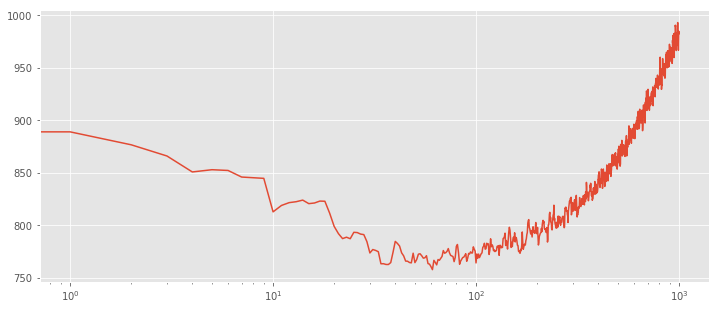

In [12]:
model_2.fit(X, y)
losses = np.array(model_2.loss_history)
fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

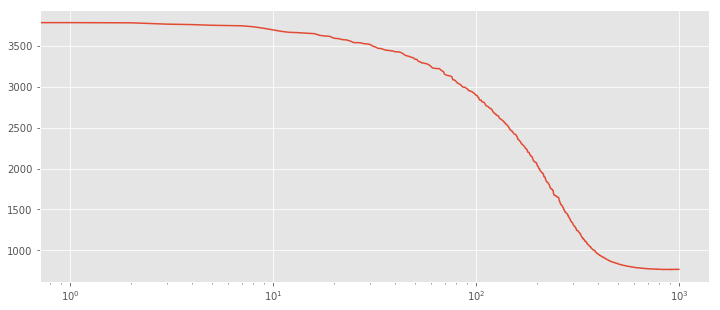

In [13]:
model_3.fit(X, y)
losses = np.array(model_3.loss_history)
fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

### Построим несколько графиков для alpha 0.005, 0.0005 и 0.00005  с уровнем регуляризации L1:

In [14]:
model_l1_1 = MySGDClassifier(max_epoch=100, log_loss=True, penalty='l1', alpha=0.005, C=0.01)
model_l1_2 = MySGDClassifier(max_epoch=100, log_loss=True, penalty='l1', alpha=0.0005, C=0.01)
model_l1_3 = MySGDClassifier(max_epoch=100, log_loss=True, penalty='l1', alpha=0.00005, C=0.01)

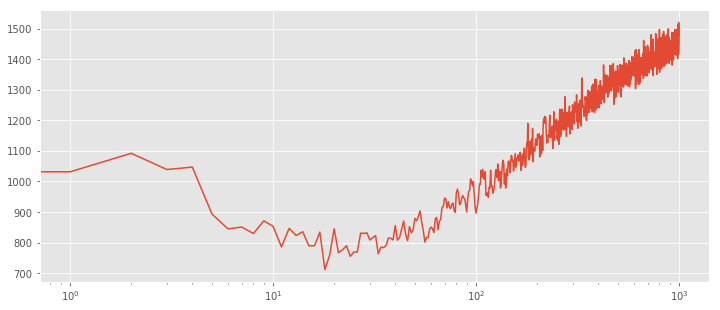

In [15]:
model_l1_1.fit(X, y)
losses = np.array(model_l1_1.loss_history)
fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

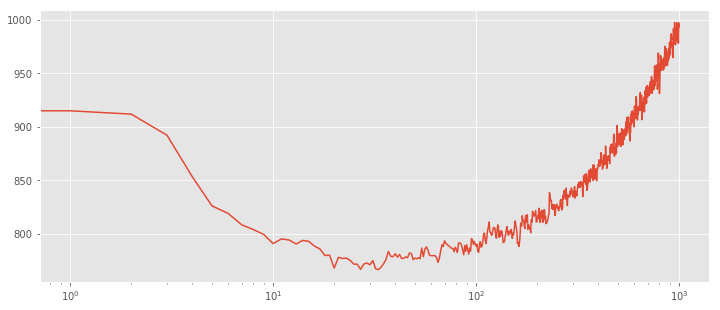

In [16]:
model_l1_2.fit(X, y)
losses = np.array(model_l1_2.loss_history)
fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

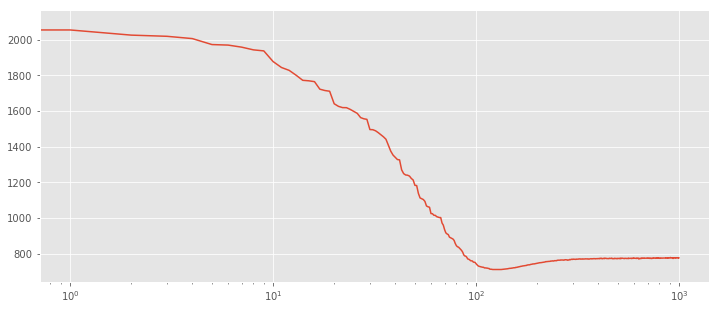

In [17]:
model_l1_3.fit(X, y)
losses = np.array(model_l1_3.loss_history)
fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

### Построим несколько графиков для alpha 0.005, 0.0005 и 0.00005 с уровнем регуляризации L2:

In [18]:
model_l2_1 = MySGDClassifier(max_epoch=100, log_loss=True, penalty='l2', alpha=0.005, C=0.01)
model_l2_2 = MySGDClassifier(max_epoch=100, log_loss=True, penalty='l2', alpha=0.0005, C=0.01)
model_l2_3 = MySGDClassifier(max_epoch=100, log_loss=True, penalty='l2', alpha=0.0001, C=0.01)

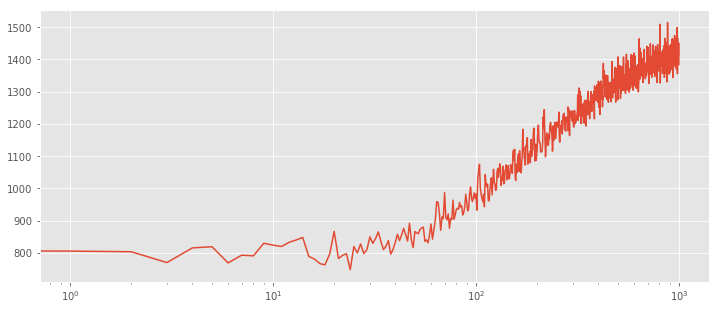

In [19]:
model_l2_1.fit(X, y)
losses = np.array(model_l2_1.loss_history)
fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

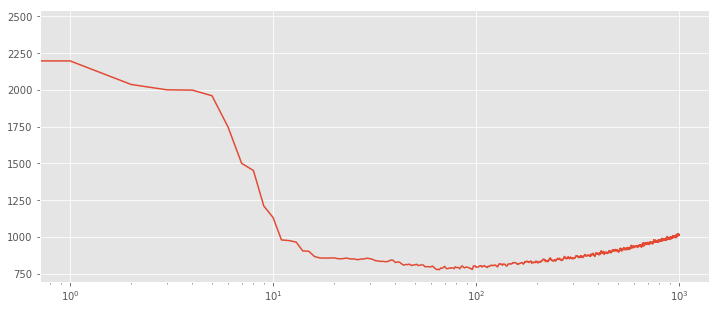

In [20]:
model_l2_2.fit(X, y)
losses = np.array(model_l2_2.loss_history)
fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

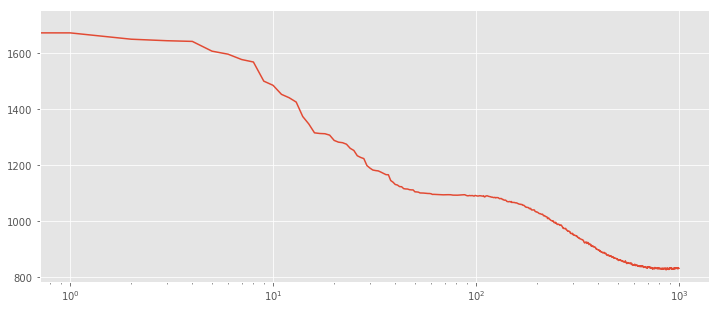

In [21]:
model_l2_3.fit(X, y)
losses = np.array(model_l2_3.loss_history)
fig, ax= plt.subplots(1, 1)
ax.set_xscale('log')
plt.plot(losses);

Как видно, для всех моделей наиболее оптимальная скорость спуска alpha равна 0.00005. 

## Попробуем посмотреть как обучается модель более наглядно:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
num_iters = 1000

### Сначала без регуляризации (с наиболее оптимальной alpha=0.00005)

In [23]:
model = MySGDClassifier(max_epoch=1, penalty=None, alpha=0.00005)

train_scores = []
test_scores = []

for i in range(num_iters):
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

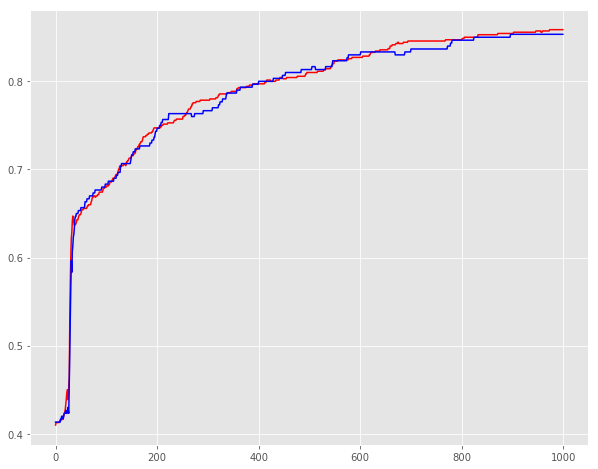

In [24]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

### Сначала с уровнем регуляризации L1 (с наиболее оптимальной alpha=0.00005)

In [25]:
model_l1 = MySGDClassifier(max_epoch=1, penalty='l1', alpha=0.00005, C=0.01)

train_scores = []
test_scores = []

for i in range(num_iters):
    model_l1.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model_l1.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model_l1.predict(X_test)))

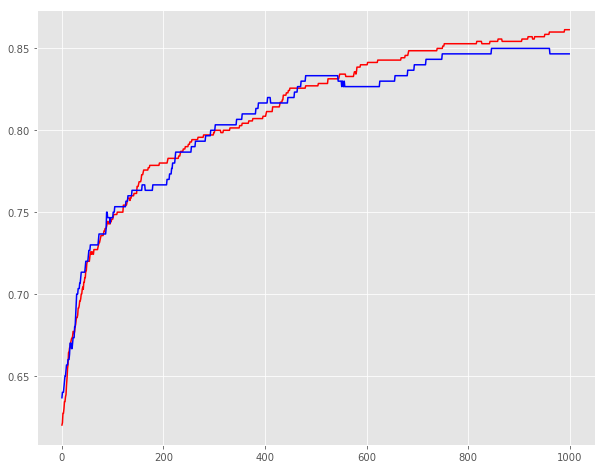

In [26]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

### Теперь  с уровнем регуляризации L2 (с наиболее оптимальной alpha=0.00005):

In [27]:
model_l2 = MySGDClassifier(max_epoch=1, penalty='l2', alpha=0.00005, C=0.01)

train_scores = []
test_scores = []

for i in range(num_iters):
    model_l2.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model_l2.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model_l2.predict(X_test)))

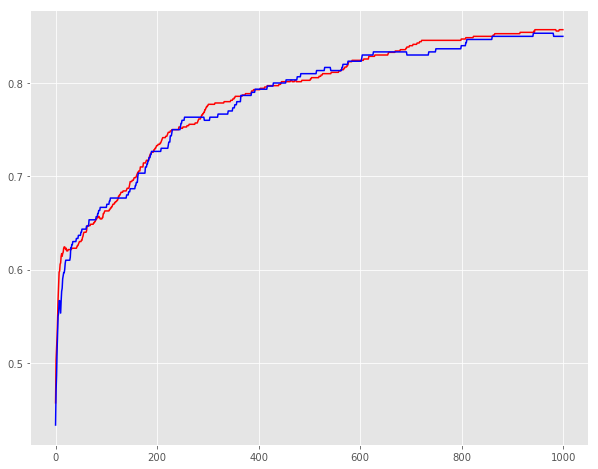

In [28]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b');

## Сравним с эталонной реализацией из sklearn:

In [29]:
from sklearn import linear_model

### Без регуляризации (с наиболее оптимальной alpha=0.00005):

In [30]:
model = MySGDClassifier(max_epoch=1000, penalty=None, alpha=0.00005)
model.fit(X_train, y_train)

clf = linear_model.SGDClassifier(n_iter=1000, loss='log', penalty=None)
clf.fit(X_train, y_train)

print('MySGDClassifier Train f1-score = %.3f' % accuracy_score(y_train, model.predict(X_train)))
print('MySGDClassifier Test f1-score = %.3f' % accuracy_score(y_test, model.predict(X_test)))

print('SGDClassifier Train f1-score = %.3f' % accuracy_score(y_train, clf.predict(X_train)))
print('SGDClassifier Test f1-score = %.3f' % accuracy_score(y_test, clf.predict(X_test)))

MySGDClassifier Train f1-score = 0.866
MySGDClassifier Test f1-score = 0.853
SGDClassifier Train f1-score = 0.877
SGDClassifier Test f1-score = 0.853


### С уровнем регуляризации L1 (с наиболее оптимальной alpha=0.00005):

In [31]:
model_l1 = MySGDClassifier(max_epoch=1000, penalty='l1', alpha=0.00005, C=0.01)
model_l1.fit(X_train, y_train)

clf_l1 = linear_model.SGDClassifier(n_iter=1000, loss='log', penalty='l1')
clf_l1.fit(X_train, y_train)

print('MySGDClassifier L1 Train f1-score = %.3f' % accuracy_score(y_train, model_l1.predict(X_train)))
print('MySGDClassifier L1 Test f1-score = %.3f' % accuracy_score(y_test, model_l1.predict(X_test)))

print('SGDClassifier L1 Train f1-score = %.3f' % accuracy_score(y_train, clf_l1.predict(X_train)))
print('SGDClassifier L1 Test f1-score = %.3f' % accuracy_score(y_test, clf_l1.predict(X_test)))

MySGDClassifier L1 Train f1-score = 0.866
MySGDClassifier L1 Test f1-score = 0.850
SGDClassifier L1 Train f1-score = 0.876
SGDClassifier L1 Test f1-score = 0.853


### С уровнем регуляризации L2 (с наиболее оптимальной alpha=0.00005):

In [32]:
model_l2 = MySGDClassifier(max_epoch=1000, penalty='l2', alpha=0.00005, C=0.01)
model_l2.fit(X_train, y_train)

clf_l2 = linear_model.SGDClassifier(n_iter=1000, loss='log', penalty='l2')
clf_l2.fit(X_train, y_train)

print('MySGDClassifier L2 Train f1-score = %.3f' % accuracy_score(y_train, model_l2.predict(X_train)))
print('MySGDClassifier L2 Test f1-score = %.3f' % accuracy_score(y_test, model_l2.predict(X_test)))

print('SGDClassifier L2 Train f1-score = %.3f' % accuracy_score(y_train, clf_l2.predict(X_train)))
print('SGDClassifier L2 Test f1-score = %.3f' % accuracy_score(y_test, clf_l2.predict(X_test)))

MySGDClassifier L2 Train f1-score = 0.846
MySGDClassifier L2 Test f1-score = 0.837
SGDClassifier L2 Train f1-score = 0.876
SGDClassifier L2 Test f1-score = 0.847


Как видно, наилучшая точность была на стандартной модели без регуляризации. Модель с уровнем регуляризации L1 несколько ей уступает, но погрешность невелика и во многом зависит от рандома. Модель с уровнем регуляризации L2 сильно отстает в точности прогноза, но для L2 регуляризации и модель sklearn оказалась не так точна.